In [15]:
##Business Analytics SQL Project

In [16]:
##DATA OVERVIEW

import sqlite3
import pandas as pd
import numpy as np

#Connect to SQLite database
conn = sqlite3.connect('sql_business_analytics.db')
cursor = conn.cursor() #execute SQL commands

#new table, unique ID for each customer, no duplicates
cursor.execute("""
CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY,
    signup_date DATE,
    region TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT,
    category TEXT,
    price REAL
);
""")

#Foreign key links orders to customers
cursor.execute("""
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date DATE,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
""")

#Order can have multiple products, one product may appear in multiple orders
cursor.execute("""
CREATE TABLE IF NOT EXISTS order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
);
""")

conn.commit()


In [17]:
##GENERATE DATA

np.random.seed(42)
num_customers = 200
num_orders = 500

customers = pd.DataFrame({
    "customer_id": range(1, num_customers + 1),
    "signup_date": pd.to_datetime("2023-01-01") +
            pd.to_timedelta(np.random.randint(0, 365, num_customers), unit="D"),
    "region": np.random.choice(["East", "West", "Midwest", "South"], num_customers)
})

products = pd.DataFrame({
    "product_id": range(1, 21),
    "product_name": [f"Product {i}" for i in range(1, 21)],
    "category": np.random.choice(["Electronics", "Clothing", "Home", "Food"], 20),
    "price": np.round(np.random.uniform(5, 100, 20), 2)
})

orders = pd.DataFrame({
    "order_id": range(1, num_orders + 1),
    "customer_id": np.random.choice(customers["customer_id"], num_orders),
    "order_date": pd.to_datetime("2023-01-01") +
                  pd.to_timedelta(np.random.randint(0, 365, num_orders), unit="D")
})

order_items_list = []
order_item_id = 1

#Orders contain 1-3 Products, quantities vary, realistic calculations
for order_id in orders["order_id"]:
  num_items = np.random.randint(1,4)
  product_ids = np.random.choice(products["product_id"], num_items)

  for product_id in product_ids:
    order_items_list.append({
      "order_item_id": order_item_id,
      "order_id": order_id,
      "product_id": product_id,
      "quantity": np.random.randint(1,5)
    })
    order_item_id += 1

order_items = pd.DataFrame(order_items_list)

customers.to_sql("customers", conn, if_exists="replace", index=False)
products.to_sql("products", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
order_items.to_sql("order_items", conn, if_exists="replace", index=False)

pd.read_sql_query("SELECT * FROM customers LIMIT 5", conn)


,customer_id,signup_date,region
0,1,2023-04-13 00:00:00,West
1,2,2023-12-15 00:00:00,Midwest
2,3,2023-09-28 00:00:00,East
3,4,2023-04-17 00:00:00,East
4,5,2023-03-13 00:00:00,East


In [18]:
##JOINS, customers

#SQL pairs rows where IDs match
query = """
SELECT
   o.order_id,
   o.order_date,
   c.region
FROM orders o
JOIN customers c
   ON o.customer_id = c.customer_id
LIMIT 5;
"""
pd.read_sql_query(query, conn)

#Revenue Calculation: Revenue = price * quantity
#SQL computes new columns, given a readable name
query = """
SELECT
   oi.order_id,
   p.product_name,
   p.category,
   oi.quantity,
   p.price,
   oi.quantity * p.price AS revenue
FROM order_items oi
JOIN products p
   ON oi.product_id = p.product_id
LIMIT 5;
"""
pd.read_sql_query(query, conn)

#Total Revenue by Category
#SUM adds revenues, grouped by a row per category, ordered by highest first
query = """
SELECT
   p.category,
   SUM(oi.quantity * p.price) AS total_revenue
FROM order_items oi
JOIN products p
   ON oi.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC;
"""
pd.read_sql_query(query, conn)

#Top Customers
query = """
SELECT
   c.customer_id,
   c.region,
   SUM(oi.quantity * p.price) AS total_spent
FROM customers c
JOIN orders o
   ON c.customer_id = o.customer_id
JOIN order_items oi
   ON o.order_id = oi.order_id
JOIN products p
   ON oi.product_id = p.product_id
GROUP BY c.customer_id, c.region
ORDER BY total_spent DESC
LIMIT 10;
"""
pd.read_sql(query,conn)


,customer_id,region,total_spent
0,145,East,2860.83
1,144,South,2694.00
2,99,South,2415.62
3,118,South,2133.00
4,23,South,2124.63
5,47,East,2072.73
6,12,South,1871.30
7,153,South,1840.66
8,154,South,1814.79
9,8,Midwest,1785.53


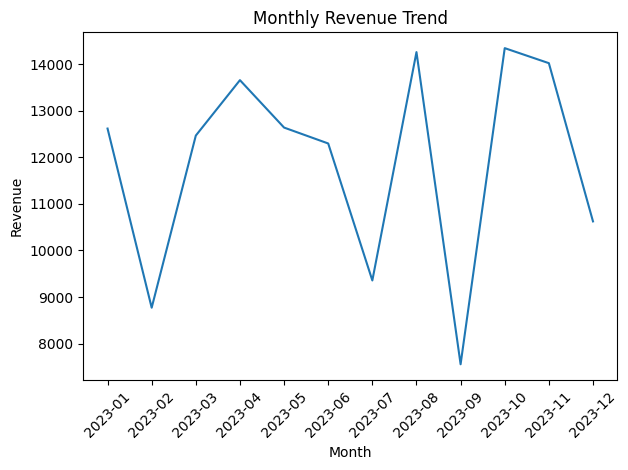

In [19]:
##MONTHLY TRENDS

query = """
SELECT
  strftime('%Y-%m', o.order_date) AS month,
    SUM(oi.quantity * p.price) AS monthly_revenue
FROM orders o
JOIN order_items oi
    ON o.order_id = oi.order_id
JOIN products p
    ON oi.product_id = p.product_id
GROUP BY month
ORDER BY month;
"""
monthly_revenue = pd.read_sql(query, conn)
monthly_revenue

import matplotlib.pyplot as plt

plt.figure()
plt.plot(monthly_revenue["month"], monthly_revenue["monthly_revenue"])
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue Trend")
plt.tight_layout()
plt.show()

Monthly Trend Insights
- Revenue fluctuates significantly month-to-month, ranging from ~7500 to ~14,000, indicating short-term volatility in demand
- Peaks occur in Jan, Mar, Apr, Aug, and Oct, while notable dips occur in Feb, Jul, Sep, and Dec, suggesting possible seasonal effects or irregular purchasing patterns
- Overall, there is no sustained upward or downward trend over the year, implying relative stability in aggregate revenue
- LOWS: September, potential risk
- HIGHS: August & October, potential opportunities

In [20]:
##PARETO ANALYSIS
## - How concentrated is revenue across customers?

query = """
SELECT
   c.customer_id,
   SUM(oi.quantity * p.price) AS total_spent
FROM customers c
JOIN orders o
   ON c.customer_id = o.customer_id
JOIN order_items oi
   ON o.order_id = oi.order_id
JOIN products p
   ON oi.product_id = p.product_id
GROUP BY c.customer_id
ORDER BY total_spent DESC;
"""
customer_revenue = pd.read_sql(query, conn)
customer_revenue

total_revenue = customer_revenue["total_spent"].sum()
customer_revenue["cumulative_revenue"] = customer_revenue["total_spent"].cumsum()
customer_revenue["cumulative_revenue_pct"] = (
    customer_revenue["cumulative_revenue"] / total_revenue
)
customer_revenue.head()

,customer_id,total_spent,cumulative_revenue,cumulative_revenue_pct
0,145,2860.83,2860.83,0.020056
1,144,2694.00,5554.83,0.038942
2,99,2415.62,7970.45,0.055877
3,118,2133.00,10103.45,0.070831
4,23,2124.63,12228.08,0.085725


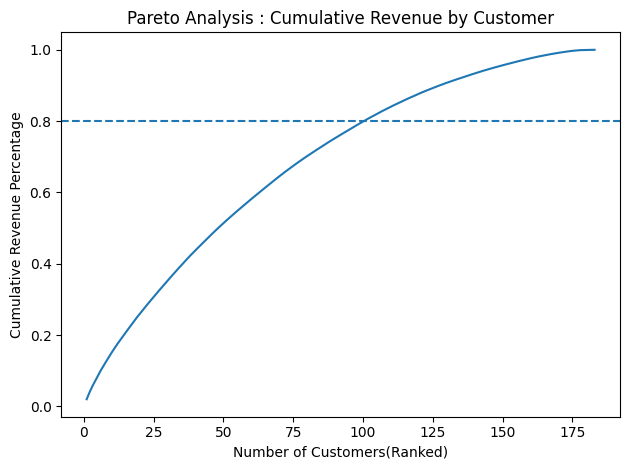

In [21]:
plt.figure()
plt.plot(
    range(1, len(customer_revenue) + 1),
    customer_revenue["cumulative_revenue_pct"]
)
plt.axhline(0.8, linestyle="--")
plt.xlabel("Number of Customers(Ranked)")
plt.ylabel("Cumulative Revenue Percentage")
plt.title("Pareto Analysis : Cumulative Revenue by Customer")
plt.tight_layout()
plt.show()

Pareto Analysis Insights
- Revenue is highly concentrated among a subset of customers, with the curve showing rapid cumulative growth and leveling off around x ≈ 175 customers
- Approximately the top ~100 customers account for roughly 80% of total revenue, consistent with  Pareto behavior
- Overall performance depends disproportionately on high-value customers
- These results suggest that retention and engagement strategies should focus on the top revenue-generating customers to minimize risk and maximize returns


Key Takeaways
- While average performance appears stable, the system is sensitive to variability among high-value customers and during low-demand months
- Combined analysis of time trends, product categories, and customer concentration provides a holistic understanding of revenue drivers, risks, and operational priorities